# Practical power 2: Sample size calculations and the perils of empirical effect size estimates
The big chicken-and-egg problem in power analysis is effect size. To calculate the required sample size for a new experiment, we need an estimate of standardized effect size. But it seems unlikely that the experiment would be interesting to us if we already knew that much about the effect. Even when we have a comparable previous experiment available, there are many ways in which that empirical effect size estimate can turn out to be wildly inaccurate (and in particular, optimistic) for the current study.

In this notebook we focus on how to perform sample size calculations. We will use simulations to illustrate some common caveats when powering according to empirical effect size estimates from previous studies. We will focus on the simple case of detecting a difference between two means in a within-subjects design, where the relevant effect size is Cohen's $d_z$, and a between-subjects design, where the relevant effect size is Cohen's $d_s$. But nothing we discuss here is specific to these particular cases.

Before we begin, make sure that you are up to speed on the materials in [part 1](power_1.ipynb) of this series, where we discussed how the positive and negative predictive value quantifies how reproducibility is influenced by statistical power $1-\beta$ and the adopted significance threshold $\alpha$.

In [27]:
# imports
import numpy as np
from scipy import stats
import pandas as pd
from statsmodels.stats import power
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

# these classes from statsmodels are useful
ttest_paired = power.TTestPower()
ttest_unpaired = power.TTestIndPower()

## Understanding Cohen's $d$
Cohen's $d$ is a standardised difference score, that is, it expresses how much two means differ in standard deviation units. There are *many* flavours of $d$, which differ in how the standard deviation is estimated. Fortunately, most of these variants are relevant for meta analysis rather than sample size calculations, so we can safely ignore them here ([Lakens, 2013](https://doi.org/10.3389/fpsyg.2013.00863) is an accessible review). But it's worth remembering this complexity when seeing $d$ reported in papers - the quantity reported may not be what you need if you are trying to calculate sample sizes according to an empirical effect size estimate. As we will see, the $d$ variants we need for sample size calculations can be obtained from reported $T$ statistics and sample sizes, so this is probably a safer route than assuming that the correct $d$ is reported.

### Within-subjects designs: Cohen's $d_z$
For a paired $T$ test (or equivalently, a one-sample $T$), we obtain $d_z$ by simply taking the mean difference divided by the sample standard deviation of the individual difference scores. There is also a handy conversion from $T$ to $d$:

$$d_z = T / \sqrt(n)$$

Notice how simple the below code is. Who said power calculations are difficult?

In [28]:
n = 20
# population effect size
d_pop = .5
differences = np.random.randn(20) + d_pop
# careful - numpy standard deviation does not include Bessel's correction by default
d_z = differences.mean() / differences.std(ddof=1)
T = stats.ttest_1samp(differences, 0).statistic
d_z_alt = T / np.sqrt(n)
print(f"d_z from formula: {d_z}")
print(f"d_z from T conversion: {d_z_alt}")

d_z from formula: 0.6302393183109785
d_z from T conversion: 0.6302393183109783


You may notice that we entered a true effect size of $d=0.5$ in the above. But if we run the above code cell a few times to simulate repeated experiments with $N=20$, the estimated $d$ is often quite different from the population effect. We will return to this point below.

### Example sample sizes for $d$
[Cohen (1988)](https://books.google.co.uk/books?id=rEe0BQAAQBAJ&lpg=PP1&ots=svZUMxOWs7&lr&pg=PP1#v=onepage&q&f=false) proposed a set of guidelines for what could be considered a small ($d=0.2$), medium ($d=0.5$) and large ($d=0.8$) effect in the behavioral sciences. These labels remain popular despite their somewhat arbitrary nature, so it's useful to get a feeling for what sample sizes these effect sizes correspond to under different experimental designs.

Here we will explore how adjusting for multiple testing (the classic Bonferroni $\alpha / n$ correction), one-tailed vs two-tailed p values, and experimental design (within- vs between-subjects) modifies the required sample size for 80% power.

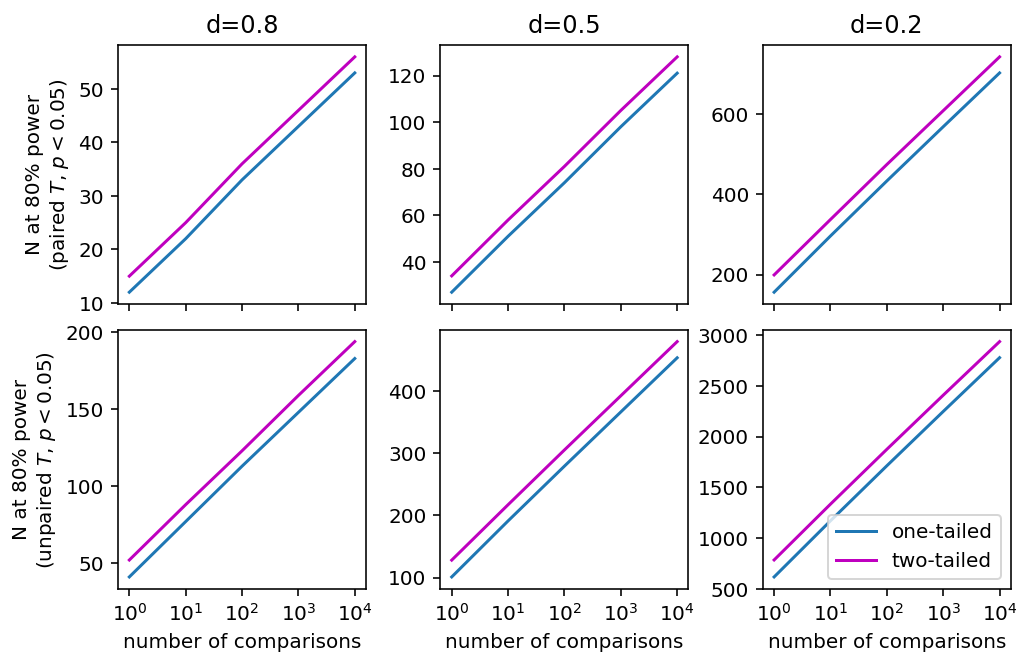

In [29]:
n_comp = 10 ** np.arange(0, 5)
example_d = (0.8, 0.5, 0.2)
# nb need to multiply ttest_unpaired by 2 since it returns n PER GROUP and we are most interested
# in TOTAL sampling requirements
n_df = (pd.DataFrame({'n_comp': n_comp,
                   'n_within_one': [np.ceil(ttest_paired.solve_power(effect_size=this_d, alpha=(0.05 / n), power=0.8, alternative='larger'))
                                    for n in n_comp],
                   'n_within_two': [np.ceil(ttest_paired.solve_power(effect_size=this_d, alpha=(0.05 / n), power=0.8, alternative='two-sided'))
                                    for n in n_comp],
                   'n_between_one': [np.ceil(2 * ttest_unpaired.solve_power(effect_size=this_d, alpha=(0.05 / n), power=0.8, alternative='larger'))
                                     for n in n_comp],
                   'n_between_two': [np.ceil(2 * ttest_unpaired.solve_power(effect_size=this_d, alpha=(0.05 / n), power=0.8, alternative='two-sided'))
                                     for n in n_comp]}) for this_d in example_d)

fig, ax = plt.subplots(2, len(example_d), figsize=(8, 5), sharex=True, sharey=False,
                      subplot_kw=dict(xscale='log', xticks=n_comp[::1]))
ax = ax.T

for this_col, this_df, this_d in zip(ax, n_df, example_d):
    ax1 = this_col[0]
    ax1.plot(this_df['n_comp'], this_df['n_within_one'], label='one-tailed')
    ax1.plot(this_df['n_comp'], this_df['n_within_two'], 'm', label='two-tailed')
    ax1.set_title(f'd={this_d}')

    ax2 = this_col[1]
    ax2.plot(this_df['n_comp'], this_df['n_between_one'], label='one-tailed')
    ax2.plot(this_df['n_comp'], this_df['n_between_two'], 'm', label='two-tailed')
    ax2.set_xlabel('number of comparisons')
    if np.all(this_col == ax[0]):
        ax1.set_ylabel('N at 80% power\n(paired $T$, $p<0.05$)')
        ax2.set_ylabel('N at 80% power\n(unpaired $T$, $p<0.05$)')
ax2.legend(loc='lower right')    

plt.subplots_adjust(wspace=.3, hspace=.1)

These plots remind us of a few basic facts about sample size calculations.

* Within-subjects designs are *much* more powerful than between-subjects designs (in rows). For many types of data (e.g., functional MRI) it is too expensive to estimate medium or small between-subjects effects with adequate power.
* There is a log-linear relationship between the number of planned comparisons and the sample size that achieves 80% power (note the log scale on the x axis in these plots). More concretely, this implies that adding another comparison has less and less effect on the required sample size as you increase the total number of planned comparisons. I have been involved in a few lengthy discussions with colleagues about the merits of adding a fourth or a fifth or a seventh planned comparison to a study. But as we can see, another comparison quickly comes to make next to no difference to the required sample size (or equally, the achieved power if we do not modify sample size).
* Substituting a one-tailed for a two-tailed test does not substantially affect the required sample size. 
* Reading off the plots, we can see that the convention in my field (psychology and cognitive neuroscience) for $N=20$ within-subjects designs affords adequate power for large effects with adjustment for about 10 planned comparisons (top left panel). $N=20$ does not achieve adequate power for medium-sized effects, even when powering according to a single one-tailed comparison (top middle panel).
* The situation is even worse for between-subject designs, where some investigators persist with $N=20$, but now *per group* (so total $N=40$). We have *just* enough power to detect a large effect in a one-tailed test with no adjustment for multiple comparisons (bottom left panel, start of blue line). But for medium and small effects the required sample sizes for adequate power are 1 and 2 orders or magnitude greater respectively. 

## Powering studies based on previous results
Getting your effect size estimate from a previous related study seems like a very reasonable thing to do. But it can easily lead us astray. The two main issues are 1) like any statistic, Cohen's $d$ is estimated with error, and the magnitude of this error can be quite substantial even when we have adequate statistical power, 2) it's easy to end up with a biased effect size estimate by selecting significant comparisons over multiple candidate tests. Let's get a feeling for the magnitude of these issues with numerical simulations.

In [30]:
# hyper parameters. You can tune these to explore how the plots below change
# effect size you think is reasonable
d_target = 0.5
# smallest effect size you could conceivably care about
d_min = .2
# largest effect size you could conceivably care about
d_max = 1.5
# significance threshold
alpha = 0.05

### Variance of cohen's $d$
left: plot histogram of d for d=0.5, N for 80% power. Mark inter-quartiles with vertical lines.
Even with adequate power, effect size estimate isn't necessarily as tight as you might imagine.

right: plot inter-quartile ranges for N corresponding to 20:99% power. With low power,
you have *no* handle on effect size, which can lead to more underpowered research.
(need double x axis for this to work well)

In [31]:
# sample sizes from low to very high power
n_low = int(np.ceil(ttest_paired.solve_power(effect_size=d_target, 
                                             alpha=alpha, power=0.2, alternative="larger")))
n_high = int(np.ceil(ttest_paired.solve_power(effect_size=d_target, 
                                              alpha=alpha, power=0.8, alternative="larger")))
n_all = np.arange(n_low, n_high, 3)

nsim = 10000
all_df = []
for this_n in n_all:
    # for a one-sample T, you can just use gaussian random numbers offset by a constant.
    # why doesn't this quite work? All the d means are slightly over the expected value,
    # and bias appears larger for smaller N. Need T distribution? Hm.
    this_data = np.random.standard_normal(size=(this_n, nsim)) + d_target
    this_d = this_data.mean(axis=0) / this_data.std(axis=0, ddof=1)
    all_df.append(pd.DataFrame({"$d$": this_d, "n": this_n, "power": 
                                np.round(ttest_paired.solve_power(effect_size=d_target,
                                                         alpha=alpha,
                                                         alternative="larger",
                                                        nobs=this_n), 2)}))
all_df = pd.concat(all_df)

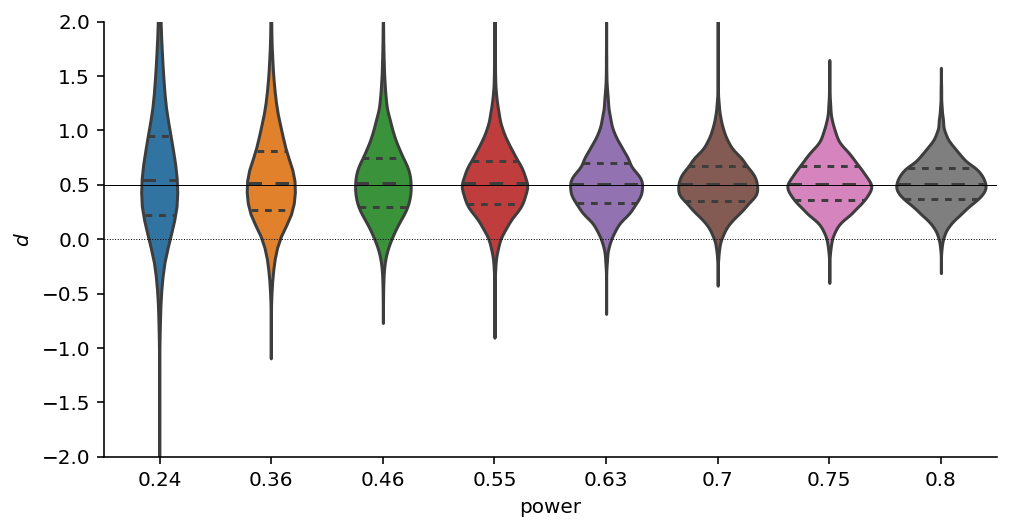

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(y="$d$", x="power", inner="quart", data=all_df, ax=ax)
sns.despine()
ax.set_ylim([-2, 2])
ax.set_xlim(ax.get_xlim())
ph = ax.plot(ax.get_xlim(), [d_target, d_target], "k", linewidth=.5)
ph = ax.plot(ax.get_xlim(), [0, 0], "k:", linewidth=.5)
# supporting lines for d=.5, d=0, power=20%, power=80%

I think power here is just the proportion of the distribution that goes under the significance threshold.
Which I guess we can work out and plot as a supporting line.

This whole plot would work better transposed. How do you do that with sns?

In [ ]:
# todo, combine with above
ax = plt.subplot(1, 2, 1)
ax.hist(this_d)
# TODO - percentiles
ax.plot([[0.,.5],[0., 0.5]], np.repeat(np.array(ax.get_ylim())[:,None],2, axis=1), ":k")
ax.set_xlabel('effect size (d)')
ax.set_ylabel('frequency')
ax.set_title(f"N={n_all[-1]}, 95% power (paired T, p<0.05, one-tailed)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# figure: bias of cohen's d
left: Pick the peak d from a set of comparisons, where d=0.5 for all. Plot out over n comparisons. Even with
a small set of comparisons, the d you get from the peak exhibits huge bias.

right: Same exercise, but working with median d over some threshold (a 'blob'). Still massive bias.

# figure: winner's curse
Plot d at 'significant' test only. With increasing n, this bias reduces.

# figure: resource tradeoff
Fix total N to something, plot out how many experiments you can run at 80% power as a function of
effect size.

In [ ]:
n_total = 2000
critical_n = []
n_experiments = []
effect_sizes = np.linspace(d_min, d_max, 100)
critical_n = [np.ceil(ttest_paired.solve_power(effect_size=d, alpha=0.05, power=0.8, alternative='two-sided')) for d in effect_sizes]

n_experiments = np.floor(n_total / np.array(critical_n))

In [ ]:
ax = plt.subplot(1, 1, 1)
ax.plot(effect_sizes, critical_n)
ax.set_xlabel('effect size (d)')
ax.set_ylabel('sample size for 80% power (N)')
ax.set_title('paired T-test, p<0.05, two-tailed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('d_vs_n.pdf')

In [ ]:
# plot by number of experiments instead. Harder to explain. Use the above variant instead.
ax = plt.subplot(1, 1, 1)
ax.plot(effect_sizes, n_experiments)
ax.set_xlabel('effect size (d)')
ax.set_ylabel('number of experiments at 80% power')
ax.set_title('paired T-test, p<0.05, two-tailed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('d_vs_n_exp.pdf')